In [1]:
import mdtraj as md
import numpy as np
import pandas as pd
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;

sns.set()

In [2]:
sns.set()
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle='->',
                      linewidth=2,
                      shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)


def rename_residues(traj):
    print("Renaming residues...")
    for i, res in enumerate(traj.top._residues):
        res.resSeq = i
        if res.name[:2] == "CY":
            res.name = "CYS"
        elif res.name[:2] == "HD" or res.name[:2] == "HE":
            res.name = "HIS"
    print("Process Complete")
    return traj


def reduce_system(traj):
    print("Reducing size of system to include atoms in residue SER to ARG...")
    protein_index = traj.top.select("protein")  # find indices for atoms part of residue
    isolated_traj = md.Trajectory.atom_slice(traj, protein_index)  # trajectory isolated

    # shorten topology to include only residues SER to ARG
    ser_index = [atom.index for atom in isolated_traj.top.atoms if (atom.residue.name == "SER")]
    arg_index = [atom.index for atom in isolated_traj.top.atoms if (atom.residue.name == "ARG")]
    print("Process Complete")
    return md.Trajectory.atom_slice(isolated_traj,
                                    range(ser_index[0], arg_index[-1]))

In [9]:
# Load trajectory
traj = "140mM\helicase_140mM.dcd"
top = "140mM\helicase_140mM.parm7"
print(f"Loading trajectory for top {top} with trajectory {traj}")
loaded = md.load(traj, top=top)

# every 1000th frame for shorter trajectory
test_traj = loaded[::100]

Loading trajectory for top 140mM\helicase_140mM.parm7 with trajectory 140mM\helicase_140mM.dcd


In [10]:
# rename proteins, reduce system
traj_renamed = rename_residues(test_traj)  # rename proteins
traj_short = reduce_system(traj_renamed)

Renaming residues...
Process Complete
Reducing size of system to include atoms in residue SER to ARG...
Process Complete


In [11]:
# top to dataframe
flattened = [list(np.array(row).flat) for row in traj_short.xyz]  # array of lists of coordinate data
traj_df = pd.DataFrame(flattened)  # to dataframe
print(f"The data frame is in shape {np.shape(traj_df)}")

The data frame is in shape (100, 27849)


In [34]:
n_components= 20

In [41]:
# Incremental PCA on data
transformer = IncrementalPCA()
transformer.partial_fit(traj_df)

traj_transformed = transformer.fit_transform(traj_df)  # transform orig data
inc_var_ratio = transformer.explained_variance_ratio_

print("Incremental PCA process complete.")

C:\Users\megha\Anaconda3\lib\site-packages\sklearn\decomposition\incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
C:\Users\megha\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Incremental PCA process complete.


C:\Users\megha\Anaconda3\lib\site-packages\sklearn\decomposition\incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
C:\Users\megha\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
#Normal PCA
from sklearn.decomposition import PCA

pca = PCA(n_components)
X_pca = pca.fit_transform(traj_df)

traj_transformed_pca = pca.fit_transform(traj_df)  # transform orig data
orig_var_ratio = pca.explained_variance_ratio_

print("PCA process complete.")


PCA process complete.


In [52]:
traj_transformed_pca[0,0]

15.053681023481278

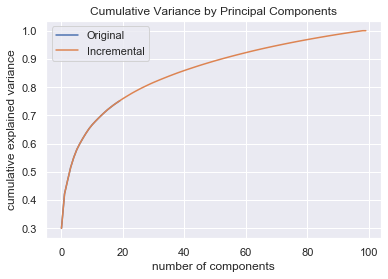

In [43]:
# plot cumulative variance explained
#plt.hist(orig_var_ratio, bins=ra, label="Original")
plt.plot(np.cumsum(orig_var_ratio), label="Original")
plt.plot(np.cumsum(inc_var_ratio), label="Incremental")
plt.title("Cumulative Variance by Principal Components")
plt.legend()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [ ]:
traj_df = traj_df.to_numpy()

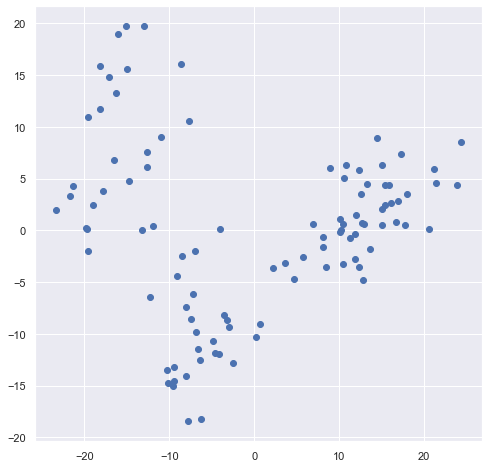

In [62]:
plt.figure(figsize=(8, 8))
plt.scatter(traj_transformed_pca[:, 0], traj_transformed_pca[:, 1])#, label=f"{i}")
#plt.legend()
plt.show()

#plot first 2 principal components against each other


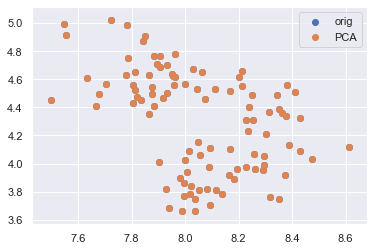

In [29]:
plt.figure()

X_new = transformer.inverse_transform(traj_transformed)
plt.scatter(traj_df[:, 0], traj_df[:, 1], label="orig")

plt.scatter(X_new[:, 0], X_new[:, 1], label="PCA")
plt.legend()
plt.show()

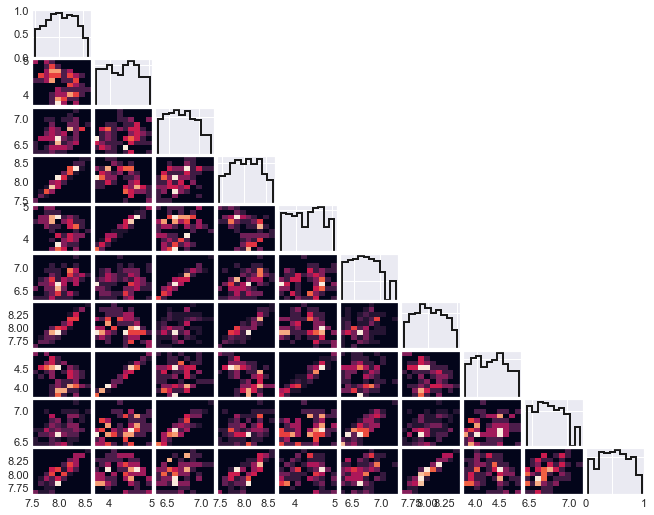

In [78]:
no_params = 10
fig,axes = plt.subplots(nrows=no_params,ncols=no_params,sharex='col',sharey='row',figsize=[10,8])
for ii in range(0,no_params):
    for jj in range(0,no_params):
        if jj>ii:
            # Plot 2D histogram and locations of selected CVs
            axes[jj,ii].hist2d(traj_df[:,ii],traj_df[:,jj],bins=10)#,norm=mpl.colors.LogNorm())
            #axes[jj,ii].plot(obs_theta[:,ii][obs_verdict==1],obs_theta[:,jj][obs_verdict==1],'.r',alpha=0.05)
        elif ii==jj:
            # Plot 1D histogram, have to make a new axis for this so it isn't sharing yscales with the 2D histograms
            axHist = fig.add_subplot(no_params, no_params, jj+ii*no_params+1)
            axHist.hist(traj_df[:,ii],bins=10,histtype='step',lw=2,color='k',log=True,density=True)
            axHist.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            axHist.xaxis.set_tick_params(which='both',labelbottom=False)
            axHist.tick_params(axis='both',direction='in',which='both')
        else:
            # Delete the top right hand corner of the triangle
            axes[jj,ii].set_visible(False)
        # Set the ticks and labels for other plots
        axes[-1,ii].xaxis.set_tick_params(which='both',labelbottom=True)
        #axes[-1,ii].set_xlabel(obs_theta_names[ii],fontsize=8,rotation=30)
        #if jj!=0:
        #    axes[jj,0].set_ylabel(obs_theta_names[jj],fontsize=8,rotation=70)
        #else:
        #    pass
        axes[jj,ii].tick_params(axis='both',direction='in',which='both')
fig.subplots_adjust(left=0.13,right=0.98,bottom=0.15,top=0.99,wspace=0.05,hspace=0.05)